In [3]:
!pip install datasets
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.3 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util

In [5]:
dataset = load_dataset('Rohit-D/synthetic-confidential-information-injected-business-excerpts', split = 'test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [85]:
import pandas as pd
import csv
import random
import os
import re
import pprint

In [86]:
pp = pprint.PrettyPrinter()
pprint = pp.pprint

In [99]:
df = pd.read_csv('/content/drive/MyDrive/Conf/fine-tuned-outputs.csv')
df.head()

,OUTPUT
0,.\nThe Zenith product development team has mad...
1,"""\nThe sentence ""We have been facing challenge..."
2,".\nThe sentence ""We have encountered unexpecte..."
3,.\nThe financial benefits from the campaign ha...
4,".\n### Reason: ""Our analysis has revealed that..."


In [100]:
MODE = 'a'
fh = open('outputs.csv', MODE)
writer = csv.writer(fh)

if MODE == 'w':
  writer.writerow(['OUTPUT'])
  fh.flush()


### **Filter out Replication in Generated Output**

In [76]:
def lcs(s1, s2):
  n1 = len(s1)
  n2 = len(s2)
  dp = {i : [0] * (n2 + 1) for i in range(n1 + 1)}

  n_lcs = 0

  for i in range(1, n1 + 1):
    for j in range(1, n2 + 1):
      if(s1[i-1] == s2[j-1]):
        dp[i][j] = 1 + dp[i-1][j-1]

      n_lcs = max(n_lcs, dp[i][j])


  return n_lcs

In [77]:
lcs("hello", "hallow")

3

In [88]:
def is_replicated(x, y):
  return lcs(x, y) > int(0.2 * max(len(x), len(y)))

In [101]:

for record_ind, record in enumerate(df['OUTPUT'].iloc[:]):
  lines = record.split('\n')
  # pprint({ind : line for ind, line in enumerate(lines)})

  replicated = [ind if ind > 0 and is_replicated(line, lines[ind-1])  else -1 for ind, line in enumerate(lines)]
  replicated = list(filter(lambda x : x >= 0, replicated))
  # print(f'Replication : {replication}')

  out = '\n'.join([line if ind not in replicated else '' for ind, line in enumerate(lines)])
  out = out[2:]
  df['OUTPUT'].iloc[record_ind] = out
  writer.writerow([out])
  print(out, end = '\n------------------------------------\n')

fh.close()

The Zenith product development team has made significant strides in overcoming technical hurdles, ensuring a seamless product launch. This information is confidential as it reveals the company's internal progress and could be used by competitors to gain an advantage.

------------------------------------
The sentence "We have been facing challenges in scaling our operations efficiently, leading to increased costs." is confidential/sensitive information because it reveals internal financial challenges that could impact investor confidence and potentially lead to a decline in stock value.

------------------------------------
The sentence "We have encountered unexpected delays in securing regulatory approvals, which may impact our projected timeline for market entry." is confidential because it discloses sensitive information about the company's regulatory approval process and potential delays, which could be used by competitors to gain an advantage in the market
------------------------

In [102]:
df.head()

,OUTPUT
0,The Zenith product development team has made s...
1,"The sentence ""We have been facing challenges i..."
2,"The sentence ""We have encountered unexpected d..."
3,The financial benefits from the campaign have ...
4,"### Reason: ""Our analysis has revealed that a ..."


In [106]:
target = dataset['Reason']
len(target)

88

In [103]:

# Load the pre-trained SBERT model
model = SentenceTransformer("all-MiniLM-L6-v2")



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Similarity between 'The cat sits outside on a sunny day.' and 'The dog plays fetch in the park with its owner.': 0.1990


In [109]:

cosine_similarities = []

for i in range(min(len(df), len(target))):
  sentence_1 = df['OUTPUT'].iloc[i]
  sentence_2 = target[i]

  embedding_1 = model.encode(sentence_1)
  embedding_2 = model.encode(sentence_2)

  cosine_similarity = util.cos_sim(embedding_1, embedding_2)
  cosine_similarities.append(cosine_similarity)

  pprint((i +1,
          sentence_1,
          sentence_2,
          f'COSINE SIMILARITY : {cosine_similarity}'))


(1,
 'The Zenith product development team has made significant strides in '
 'overcoming technical hurdles, ensuring a seamless product launch. This '
 "information is confidential as it reveals the company's internal progress "
 'and could be used by competitors to gain an advantage.\n',
 '"Zenith product development team has made significant strides in overcoming '
 'technical hurdles, ensuring a seamless product launch."**Reason for '
 'confidentiality:** This sentence discloses sensitive information about the '
 "company's internal product development process and technical challenges, "
 'which could provide valuable insights to competitors and potentially '
 "undermine the product's market advantage.",
 'COSINE SIMILARITY : tensor([[0.7120]])')
(2,
 'The sentence "We have been facing challenges in scaling our operations '
 'efficiently, leading to increased costs." is confidential/sensitive '
 'information because it reveals internal financial challenges that could '
 'impact inve

In [111]:
import matplotlib.pyplot as plt

In [123]:
x = range(len(cosine_similarities))
y = [cos_sim[0].item() for cos_sim in cosine_similarities]

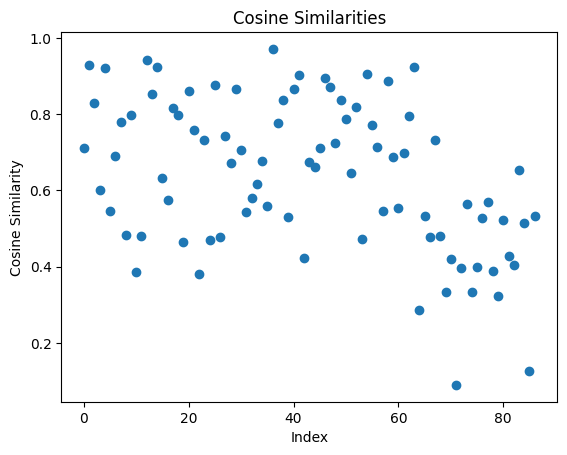

In [128]:
plt.title('Cosine Similarities')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.scatter(x, y)

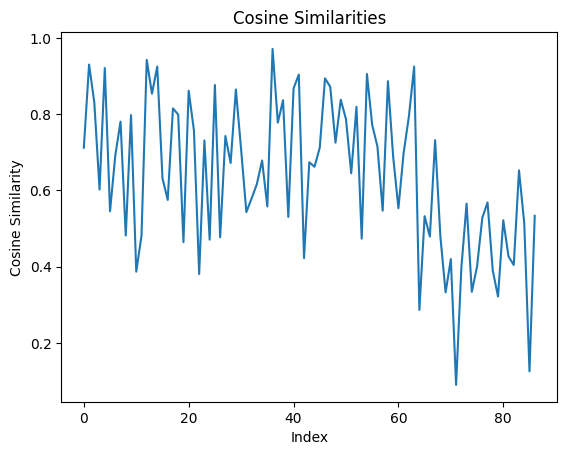

In [129]:
plt.title('Cosine Similarities')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.plot(x, y)